In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

import tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten, Embedding 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import joblib
import sounddevice as sd 
import speech_recognition as sr 
import neattext.functions as nfx 

In [2]:
TESS_DATA_PATH = r"C:\Users\Shankhni Marandi\OneDrive\Desktop\TESS Toronto emotional speech set data"
SPEECH_MODEL_SAVE_PATH = "speech_emotion_model.keras"
SPEECH_ENCODER_SAVE_PATH = "speech_onehot_encoder.pkl"

TEXT_DATA_FILE = r"C:\Users\Shankhni Marandi\OneDrive\Desktop\train.txt" 
TEXT_MODEL_SAVE_PATH = "text_emotion_model.keras" 


--- Training Speech Emotion Recognition Model ---
Loaded 2800 speech samples for training.

Initial Speech Label Counts (before filtering):
label
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64
Note: 'calm' emotion not found in TESS data. If desired, ensure it's in your dataset or adjust classes.
Speech label counts after filtering 'surprised':
label
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64

Speech Model Summary (Enhanced):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 256)           264192    
                                                                 
 dropout (Dropout)           (None, 60, 256)           0         
                                  

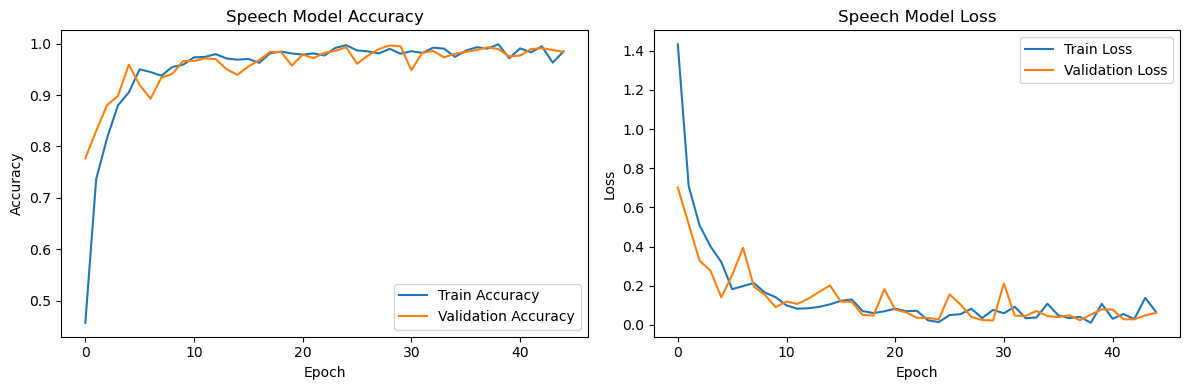

In [3]:
print("\n--- Training Speech Emotion Recognition Model ---")

speech_model_trained = False
speech_model = None
speech_enc = None

speech_paths = []
speech_labels_raw = []
target_samples_speech = 2800 

if not os.path.exists(TESS_DATA_PATH):
    print(f"ERROR: TESS_DATA_PATH '{TESS_DATA_PATH}' does not exist. Please verify the path. Skipping Speech Model Training.")
else:
    for dirname, _, filenames in os.walk(TESS_DATA_PATH):
        for filename in filenames:
            if filename.endswith('.wav'):
                full_path = os.path.join(dirname, filename)
                speech_paths.append(full_path)
                label = os.path.basename(dirname).split('_')[-1].lower()
                speech_labels_raw.append(label)
        if len(speech_paths) >= target_samples_speech:
            break

    print(f'Loaded {len(speech_paths)} speech samples for training.')

    speech_df_temp = pd.DataFrame({'label': speech_labels_raw})
    print("\nInitial Speech Label Counts (before filtering):")
    print(speech_df_temp['label'].value_counts())


    if not speech_paths:
        print("WARNING: No .wav files found in the TESS dataset path. Skipping Speech Model Training.")
    else:
        speech_df = pd.DataFrame()
        speech_df['speech'] = speech_paths
        speech_df['label'] = speech_labels_raw

        labels_to_remove_speech = ['surprised']
        speech_df = speech_df[~speech_df['label'].isin(labels_to_remove_speech)].copy()
        
        if 'calm' not in speech_df['label'].unique() and 'calm' not in speech_labels_raw:
             print("Note: 'calm' emotion not found in TESS data. If desired, ensure it's in your dataset or adjust classes.")

        print("Speech label counts after filtering 'surprised':")
        print(speech_df['label'].value_counts())

        if speech_df.empty:
            print("\nWARNING: Speech DataFrame is empty after filtering labels. Skipping Speech Model Training.")
        else:
            def extract_mfcc(filename, duration=3, offset=0.5, n_mfcc=60): 
                try:
                    y, sr = librosa.load(filename, sr=22050, duration=duration, offset=offset)
                    if y is None or len(y) == 0:
                        raise ValueError("Librosa loaded empty audio data.")
                    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T, axis=0)
                    return mfcc
                except Exception as e:
                    print(f"Failed on {filename}: {e}")
                    return None

                
            speech_X_mfcc = speech_df['speech'].apply(lambda x: extract_mfcc(x))
            speech_df['mfcc_features'] = speech_X_mfcc
            speech_df = speech_df.dropna(subset=['mfcc_features']).copy() 

            if speech_df.empty:
                print("\nWARNING: No valid speech samples found after MFCC extraction and dropping NaNs. Skipping Speech Model Training.")
            else:
                speech_X = np.array([x for x in speech_df['mfcc_features']])
                speech_X = np.expand_dims(speech_X, -1)
                
                speech_enc = OneHotEncoder(handle_unknown='ignore')
                speech_y = speech_enc.fit_transform(speech_df[['label']]).toarray()
                
                num_speech_classes = speech_y.shape[1]

                X_train_speech, X_test_speech, y_train_speech, y_test_speech = train_test_split(
                    speech_X, speech_y, test_size=0.2, random_state=42
                )

                speech_model = Sequential([
                    LSTM(256, return_sequences=True, input_shape=(speech_X.shape[1], 1)),
                    Dropout(0.3), 
                    LSTM(128, return_sequences=True), 
                    Dropout(0.3), 
                    LSTM(64), 
                    Dropout(0.3), 
                    Dense(64, activation='relu'),
                    Dropout(0.3),
                    Dense(num_speech_classes, activation='softmax') 
                ])

                speech_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                print("\nSpeech Model Summary (Enhanced):")
                speech_model.summary()

                print("\nTraining Speech Model...")
                early_stopping_speech = EarlyStopping(
                    monitor='val_loss',     
                    patience=15,            
                    restore_best_weights=True 
                )
                try:
                    speech_history = speech_model.fit(
                        X_train_speech, y_train_speech, epochs=150, batch_size=64, 
                        validation_data=(X_test_speech, y_test_speech),
                        callbacks=[early_stopping_speech], 
                        verbose=1
                    )
                    print("Speech Model Training Complete.")
                    speech_model_trained = True

                    speech_model.save(SPEECH_MODEL_SAVE_PATH)
                    joblib.dump(speech_enc, SPEECH_ENCODER_SAVE_PATH)
                    print(f"Speech model saved to {SPEECH_MODEL_SAVE_PATH}")
                    print(f"Speech OneHotEncoder saved to {SPEECH_ENCODER_SAVE_PATH}")
                    
                    plt.figure(figsize=(12, 4))
                    plt.subplot(1, 2, 1)
                    plt.plot(speech_history.history['accuracy'], label='Train Accuracy')
                    plt.plot(speech_history.history['val_accuracy'], label='Validation Accuracy')
                    plt.title('Speech Model Accuracy')
                    plt.xlabel('Epoch')
                    plt.ylabel('Accuracy')
                    plt.legend()
                               
                    plt.subplot(1, 2, 2)
                    plt.plot(speech_history.history['loss'], label='Train Loss')
                    plt.plot(speech_history.history['val_loss'], label='Validation Loss')
                    plt.title('Speech Model Loss')
                    plt.xlabel('Epoch')
                    plt.ylabel('Loss')
                    plt.legend()
                               
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"ERROR: An error occurred during speech model training: {e}")
                    speech_model_trained = False

In [ ]:
print("\n--- Training Text Emotion Recognition Model ---")

text_model_trained = False
text_model = None
tokenizer = None
label_encoder_text = None
max_length = 100 

try:
    data_text = pd.read_csv(TEXT_DATA_FILE, sep=';', header=None)
    if data_text.shape[1] < 2:
        print(f"WARNING: Data loaded with {data_text.shape[1]} columns using ';'. Trying comma separator.")
        data_text = pd.read_csv(TEXT_DATA_FILE, sep=',', header=None)
        if data_text.shape[1] < 2:
            print(f"WARNING: Data loaded with {data_text.shape[1]} columns using ','. Trying tab separator.")
            data_text = pd.read_csv(TEXT_DATA_FILE, sep='\t', header=None)
            if data_text.shape[1] < 2:
                print("ERROR: Could not parse data with common separators (';', ',', '\t'). Please check your file's delimiter.")
                data_text = pd.DataFrame() 

    if not data_text.empty and data_text.shape[1] >= 2:
        data_text.columns = ["Text", "Emotions"]
        print("\nText data loaded successfully.")
        print(data_text.head())
        print(f"\nTotal text rows loaded: {len(data_text)}")
        
        print("\nText Label Counts:")
        print(data_text['Emotions'].value_counts())


        X_text = data_text['Text'].values
        y_text = data_text['Emotions'].values

        label_encoder_text = LabelEncoder()
        y_text_encoded = label_encoder_text.fit_transform(y_text)
        num_text_classes = len(label_encoder_text.classes_)
        y_text_categorical = to_categorical(y_text_encoded, num_classes=num_text_classes)

        X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
            X_text, y_text_categorical, test_size=0.2, random_state=42
        )

        tokenizer = Tokenizer(oov_token="<unk>") 
        tokenizer.fit_on_texts(X_train_text)

        X_train_text_seq = tokenizer.texts_to_sequences(X_train_text)
        X_test_text_seq = tokenizer.texts_to_sequences(X_test_text)

        X_train_text_pad = pad_sequences(X_train_text_seq, maxlen=max_length)
        X_test_text_pad = pad_sequences(X_test_text_seq, maxlen=max_length)

        vocab_size = len(tokenizer.word_index) + 1 
        text_model = Sequential([
            Embedding(vocab_size, 128, input_length=max_length),
            LSTM(128, return_sequences=True), 
            Dropout(0.3),
            LSTM(64), 
            Dropout(0.3),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(num_text_classes, activation='softmax')
        ])

        text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print("\nText Model Summary (Enhanced):")
        text_model.summary()

        print("\nTraining Text Model...")
        early_stopping_text = EarlyStopping(
            monitor='val_loss',     
            patience=8,             
            restore_best_weights=True 
        )
        try:
            text_history = text_model.fit(
                X_train_text_pad, y_train_text, epochs=75, batch_size=32,
                validation_data=(X_test_text_pad, y_test_text),
                callbacks=[early_stopping_text], 
                verbose=1
            )
            print("Text Model Training Complete.")
            text_model_trained = True

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(text_history.history['accuracy'], label='Train Accuracy')
            plt.plot(text_history.history['val_accuracy'], label='Validation Accuracy')
            plt.title('Text Model Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.plot(text_history.history['loss'], label='Train Loss')
            plt.plot(text_history.history['val_loss'], label='Validation Loss')
            plt.title('Text Model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            
            plt.tight_layout()
            plt.show()

            text_model.save(TEXT_MODEL_SAVE_PATH)
            joblib.dump(tokenizer, TEXT_MODEL_SAVE_PATH.replace('.keras', '_tokenizer.pkl'))
            joblib.dump(label_encoder_text, TEXT_MODEL_SAVE_PATH.replace('.keras', '_label_encoder.pkl'))
            print(f"Text model saved to {TEXT_MODEL_SAVE_PATH}")
            print(f"Text tokenizer saved to {TEXT_MODEL_SAVE_PATH.replace('.keras', '_tokenizer.pkl')}")
            print(f"Text label encoder saved to {TEXT_MODEL_SAVE_PATH.replace('.keras', '_label_encoder.pkl')}")

        except Exception as e:
            print(f"An error occurred during text model training: {e}")
            text_model_trained = False
    else:
        print("\nWARNING: Text data is empty or invalid. Skipping Text Model Training.")
except FileNotFoundError:
    print(f"\nWARNING: Text dataset not found at {TEXT_DATA_FILE}. Skipping Text Model Training.")
except Exception as e:
    print(f"\nERROR: An error occurred during text data loading or processing: {e}. Skipping Text Model Training.")

In [ ]:
print("\n--- Starting Real-time Multimodal Emotion Recognition System ---")

loaded_speech_model = None
loaded_text_model = None

loaded_speech_encoder = None
loaded_text_tokenizer = None
loaded_text_label_encoder = None

if speech_model_trained:
    try:
        loaded_speech_model = load_model(SPEECH_MODEL_SAVE_PATH)
        loaded_speech_encoder = joblib.load(open(SPEECH_ENCODER_SAVE_PATH, "rb"))
        speech_model_inference_loaded = True
        print("Loaded Speech Model for inference.")
    except Exception as e:
        print(f"Could not load Speech Model or encoder for inference from {SPEECH_MODEL_SAVE_PATH}: {e}. Speech predictions will be skipped.")
else:
    print("Speech model training was skipped, so not attempting to load for inference.")

if text_model_trained:
    try:
        loaded_text_model = load_model(TEXT_MODEL_SAVE_PATH)
        loaded_text_tokenizer = joblib.load(open(TEXT_MODEL_SAVE_PATH.replace('.keras', '_tokenizer.pkl'), "rb"))
        loaded_text_label_encoder = joblib.load(open(TEXT_MODEL_SAVE_PATH.replace('.keras', '_label_encoder.pkl'), "rb"))
        text_model_inference_loaded = True
        print("Loaded Text Model for inference.")
    except Exception as e:
        print(f"Could not load Text Model or components for inference from {TEXT_MODEL_SAVE_PATH}: {e}. Text predictions will be skipped.")
else:
    print("Text model training was skipped, so not attempting to load for inference.")

speech_labels_display = loaded_speech_encoder.categories_[0].tolist() if loaded_speech_encoder else ['angry', 'disgust', 'fear', 
                                                                                                     'happy', 'neutral', 'sad', 'surprise', 'calm'] 
text_labels_display = loaded_text_label_encoder.classes_.tolist() if loaded_text_label_encoder else ["anger","disgust","fear","happy",
                                                                                                     "joy","love","neutral","sadness","surprise"] 

SR_AUDIO_REALTIME = 22050 
DURATION_AUDIO_CHUNK_REALTIME = 3 
CHANNELS_AUDIO_REALTIME = 1

def record_audio_jupyter(duration=DURATION_AUDIO_CHUNK_REALTIME, fs=SR_AUDIO_REALTIME):
    print(f"Recording started for {duration} seconds. Please speak now...")
    try:
        audio = sd.rec(int(duration * fs), samplerate=fs, channels=CHANNELS_AUDIO_REALTIME, dtype='float32')
        sd.wait() 
        print("Recording finished.")
        return np.squeeze(audio)
    except Exception as e:
        print(f"Error during audio recording: {e}")
        print("Please ensure your microphone is connected and accessible. You might need to select a specific device.")
        print("Run `import sounddevice as sd; print(sd.query_devices())` in a separate cell to see available devices.")
        return None

speech_recognizer = sr.Recognizer()

def harmonize_emotion(emotion, source_type):
    emotion_map = {
        "joy": "happy",
        "sadness": "sad",
        "calm": "neutral",
        "shame": "sad", 
        "love": "happy" 
    }
    return emotion_map.get(emotion.lower(), emotion.lower())

def fuse_emotions_simple_priority(speech_pred, text_pred):
    fused_emotion = "Undetermined"
    speech_harmonized = harmonize_emotion(speech_pred, "speech")
    text_harmonized = harmonize_emotion(text_pred, "text")

    if speech_harmonized not in ["n/a", "neutral", "calm", "prediction error", "speech model not loaded", "error"]:
        fused_emotion = speech_harmonized
    elif text_harmonized not in ["n/a", "neutral", "text model not loaded", "no speech/noise", "stt conn. error", "stt proc. error", "error"]:
        fused_emotion = text_harmonized
    elif speech_harmonized == "neutral" or text_harmonized == "neutral":
        fused_emotion = "neutral"

    return fused_emotion.capitalize()



def perform_speech_text_emotion_snapshot():

    current_speech_emotion = "N/A"
    current_recognized_text = ""
    current_text_emotion = "N/A"

    audio_data = record_audio_jupyter()
    if audio_data is None:
        return current_speech_emotion, current_recognized_text, current_text_emotion

    if loaded_speech_model and speech_model_inference_loaded:
        try:
            mfccs = np.mean(librosa.feature.mfcc(y=audio_data.astype(np.float32), sr=SR_AUDIO_REALTIME, n_mfcc=60).T, axis=0) 
            mfccs_input = np.expand_dims(mfccs, axis=(0,-1))

            pred_speech = loaded_speech_model.predict(mfccs_input, verbose=0)[0]
            current_speech_emotion = loaded_speech_encoder.categories_[0][np.argmax(pred_speech)]
            print(f"\nSpeech Emotion: {current_speech_emotion}")
        except Exception as e:
            print(f"Error processing speech audio for emotion: {e}")
            current_speech_emotion = "Error"
    else:
        print("Speech model not loaded for inference. Skipping speech emotion prediction.")

    if loaded_text_model and text_model_inference_loaded:
        print(f"Text model components loaded for inference: Model={loaded_text_model is not None}, Tokenizer={loaded_text_tokenizer is not None}, LabelEncoder={loaded_text_label_encoder is not None}") 
        try:
            audio_data_sr = sr.AudioData(audio_data.astype(np.float32).tobytes(), SR_AUDIO_REALTIME, audio_data.astype(np.float32).dtype.itemsize)
            text = speech_recognizer.recognize_google(audio_data_sr)
            current_recognized_text = text
            print(f"Recognized Text: \"{text}\"")
            
            clean_text = nfx.remove_userhandles(clean_text)
            clean_text = nfx.remove_stopwords(clean_text)


            if clean_text.strip():
                input_sequence = loaded_text_tokenizer.texts_to_sequences([clean_text])
                padded_input_sequence = pad_sequences(input_sequence, maxlen=max_length)
                
                pred_text = loaded_text_model.predict(padded_input_sequence, verbose=0)[0]
                current_text_emotion = loaded_text_label_encoder.inverse_transform([np.argmax(pred_text)])[0]
                print(f"Text Emotion: {current_text_emotion}")
            else:
                current_text_emotion = "No Speech/Noise (after cleaning)"
                print(f"Text Emotion: {current_text_emotion}")

        except sr.UnknownValueError:
            print("Speech Recognition could not understand audio.")
            current_text_emotion = "No Speech/Noise"
        except sr.RequestError as e:
            print(f"Speech Recognition Request Error: {e}")
            current_text_emotion = "STT Conn. Error"
        except Exception as e:
            print(f"Generic Error processing text from STT: {e}")
            current_text_emotion = "STT Proc. Error"
    else:
        print("Text model not loaded for inference. Skipping text emotion prediction.")

    return current_speech_emotion, current_recognized_text, current_text_emotion

print("\n--- Jupyter Notebook Multimodal Emotion System ---")
print("Run the cells below sequentially. Each 'snapshot' function will capture input and print/display results.")
print("Training models will run first (or load if already saved).")

last_speech_emotion = "N/A"
last_text_emotion = "N/A"
last_stt_text = ""


print("\n--- Performing Speech & Text Emotion Snapshot ---")
temp_speech_emotion, temp_recognized_text, temp_text_emotion = perform_speech_text_emotion_snapshot()
last_speech_emotion = temp_speech_emotion
last_recognized_text = temp_recognized_text
last_text_emotion = temp_text_emotion
print(f"Snapshot Speech Emotion: {last_speech_emotion}")
print(f"Snapshot Recognized Text: {last_recognized_text}")
print(f"Snapshot Text Emotion: {last_text_emotion}")

print("\n--- Optional: Direct Text Input Emotion Prediction ---")
if loaded_text_model is not None and loaded_text_tokenizer is not None and loaded_text_label_encoder is not None:
    print("Enter text to predict emotion. Type 'exit' to quit.")
    while True:
        try:
            input_text = input("\nEnter your text: ")
            if input_text.lower() == 'exit':
                print("Exiting direct text emotion prediction.")
                break

            input_sequence = loaded_text_tokenizer.texts_to_sequences([input_text])
            padded_input_sequence = pad_sequences(input_sequence, maxlen=max_length)

            prediction = loaded_text_model.predict(padded_input_sequence, verbose=0) 
            predicted_label = loaded_text_label_encoder.inverse_transform([np.argmax(prediction[0])])
            
            print(f"Predicted Emotion (Direct Text): {predicted_label[0]}")

        except Exception as e:
            print(f"An error occurred during direct text prediction: {e}")
            print("Please ensure your input is valid text.")
else:
    print("\nCannot perform direct text prediction: Text Model, tokenizer, or label encoder were not successfully initialized.")

print("\n--- Performing Multimodal Fusion ---")
overall_fused_emotion = fuse_emotions_simple_priority(
    last_speech_emotion,
    last_text_emotion
)
print(f"OVERALL FUSED EMOTION: {overall_fused_emotion}")

print("\nMultimodal Emotion Recognition System setup complete.")